# ltu-ili + ltu-cmass

In [1]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
from os.path import join as pjoin
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

from ili.dataloaders import NumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PlotRankStatistics, TARP
from ili.embedding import FCN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/summarizer/__init__.py:33: UserWarning: Running without the following backends due to ModuleNotFoundError: nbodykit, jax, Corrfunc, kymatio
  warnings.warn(f"Running without the following backends due to ModuleNotFoundError: {', '.join(notfound)}")


Device: cuda


## Load data

In [2]:
lh_lookup = pd.read_csv('../data/quijote/latin_hypercube_params_bonus.txt', 
                        delimiter=' ', header=None, names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
def theta_value(lhid):
    return lh_lookup.iloc[lhid+1].values

In [3]:
datapath = '../data/pmwd/L3000-N384'
simdirs = os.listdir(datapath)
kimin, kimax = 2, 41

Pktrain = []
thtrain = []
skip = []
for s in tqdm.tqdm(range(0,2000)):
    pkpath = pjoin(datapath, str(s), 'Pk')
    if osp.isdir(pkpath):
        pklist = os.listdir(pkpath)
        out = [np.load(pjoin(pkpath, x)) for x in pklist]
        out = np.array([list(x.values()) for x in out])
        
        k = out[0,0,kimin:kimax]
        out = out[:,1] # monopole
        out = out[:,kimin:kimax] # ignore largest and smallest modes
        out = np.log10(out)
        
        Pk = out # out[:,1:,:].reshape(len(out), -1)
        Pktrain.append(Pk)
        thtrain.append([theta_value(s)]*len(Pk))
    else:
        skip.append(s)

print('Skipped:', skip)

  5%|▌         | 106/2000 [00:04<01:08, 27.70it/s]/tmp/ipykernel_3184552/2653390486.py:18: RuntimeWarning: invalid value encountered in log10
  out = np.log10(out)
100%|██████████| 2000/2000 [00:59<00:00, 33.50it/s]

Skipped: [10, 304, 400, 562, 572, 834, 897, 968, 1106, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1321, 1333, 1414, 1559, 1618, 1643, 1655, 1730, 1750, 1815, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 195

In [5]:
x = np.concatenate(Pktrain)
theta = np.concatenate(thtrain)

print(x.shape, theta.shape)

(10674, 39) (10674, 5)


In [6]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)

In [7]:
# x = x[::5]
# theta = theta[::5]

In [8]:
# load real data
pkpath = '/home/mattho/git/ltu-cmass/data/obs/Pk/Pk.npz'
pkdata = np.load(pkpath)

ktrue = pkdata['k_gal']
Pktrue = pkdata['p0k_gal']
Pktrue = Pktrue[kimin:kimax]
ktrue = ktrue[kimin:kimax]
Pktrue = np.log10(Pktrue)

thtrue = lh_lookup.iloc[3]
thtrue['Omega_m'] = 0.308
thtrue['h'] = 0.678
thtrue['n_s'] = 0.968



## Train

In [9]:
# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

Text(0.5, 1.0, 'Data vectors x')

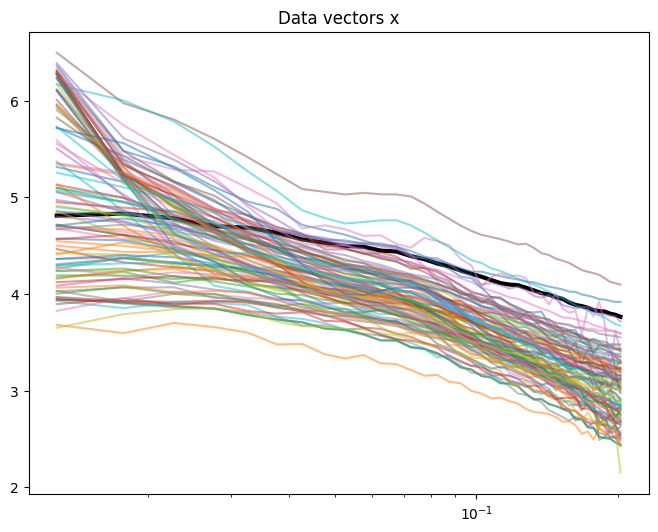

In [10]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx()
ax.plot(ktrue, Pktrue, 'k', lw=3, label='real data')
for i in range(100):
    ind = np.random.randint(len(theta))
    ax.plot(k, x[ind], alpha=0.5, label=tuple(theta[ind]))
# ax.legend(title='theta')
ax.set_title('Data vectors x')

In [11]:
lmin, lmax = lh_lookup.min(axis=0).values, lh_lookup.max(axis=0).values

In [12]:
embedding = FCN(x.shape[-1], [64, 32, 16, 8])

In [13]:
# define a prior
prior = sbi.utils.BoxUniform(low=lmin, high=lmax, device=device)

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='mdn', hidden_features=64, num_components=3),
    sbi.utils.posterior_nn(model='mdn', hidden_features=64, num_components=3),
    sbi.utils.posterior_nn(model='mdn', hidden_features=64, num_components=3),
    
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [14]:
# train the model
posterior, summaries = runner(loader=loader)

INFO:root:Training model 1 out of 3 ensemble models


 Neural network successfully converged after 246 epochs.

INFO:root:Training model 2 out of 3 ensemble models


 Neural network successfully converged after 302 epochs.

INFO:root:Training model 3 out of 3 ensemble models


 Neural network successfully converged after 277 epochs.

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 1384.5446908473969 seconds to train all models.


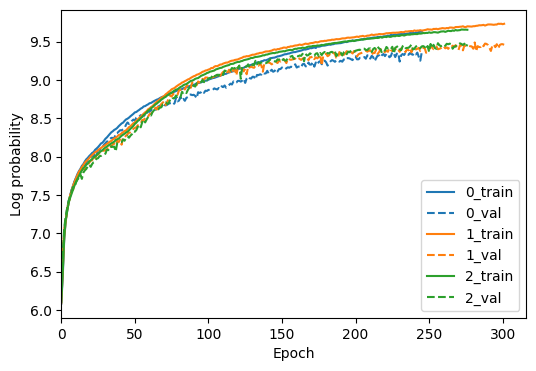

In [16]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [23]:


# choose a random input
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
samples = posterior.sample((1000,), torch.Tensor(Pktrue).to(device))

# calculate the log_prob for each sample
log_prob = posterior.log_prob(samples, torch.Tensor(Pktrue).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 318 posterior samples: 343it [00:00, 46140.03it/s]            
Drawing 334 posterior samples: 387it [00:00, 90640.81it/s]            
Drawing 348 posterior samples: 446it [00:00, 130906.90it/s]           


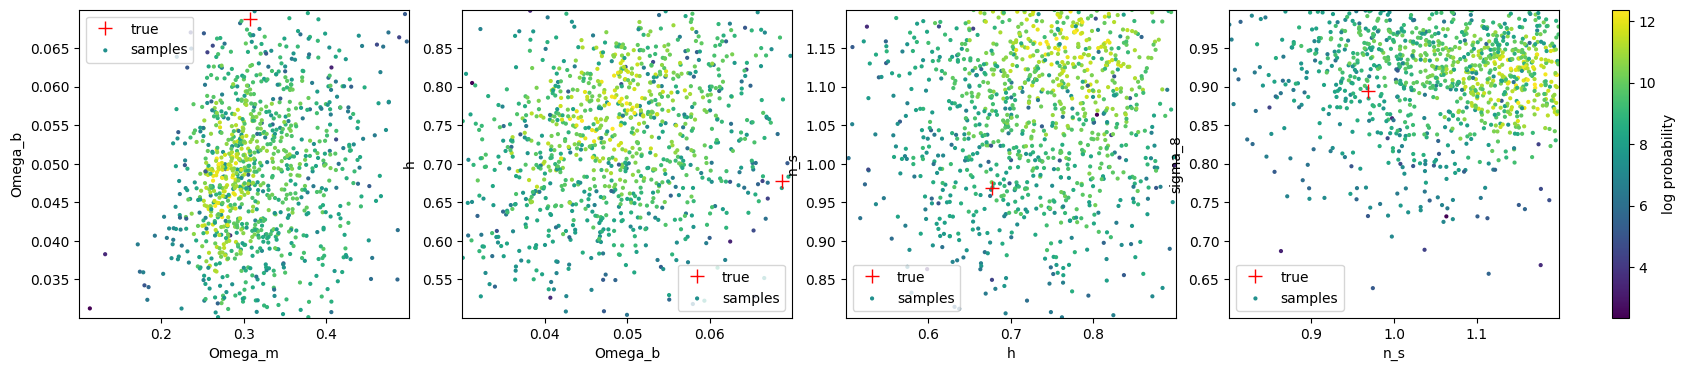

In [24]:
# plot the posterior samples and the true value
N = 4
fig, axs = plt.subplots(1, N+1, figsize=(N*5,4), gridspec_kw={'width_ratios': [1]*N+[0.05]})
for i in range(N):
    axs[i].plot(thtrue[i], thtrue[i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    # axs[i].set_aspect('equal')
    axs[i].set_xlim(lmin[i], lmax[i])
    axs[i].set_ylim(lmin[i+1], lmax[i+1])
    axs[i].set_xlabel(f'{lh_lookup.columns[i]}')
    axs[i].set_ylabel(f'{lh_lookup.columns[i+1]}')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[-1])

In [44]:
N = 2000

mus = [0.308, 0.678, 0.968, 0.811]
sigs = [0.012, 0.009, 0.006, 0.006]
x1 = np.random.normal(loc=mus, scale=sigs, size=(N,4))
x1 = pd.DataFrame(x1, columns=['Omega_m', 'h', 'n_s', 'sigma_8'])

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sea

IndexError: index 4 is out of bounds for axis 0 with size 4

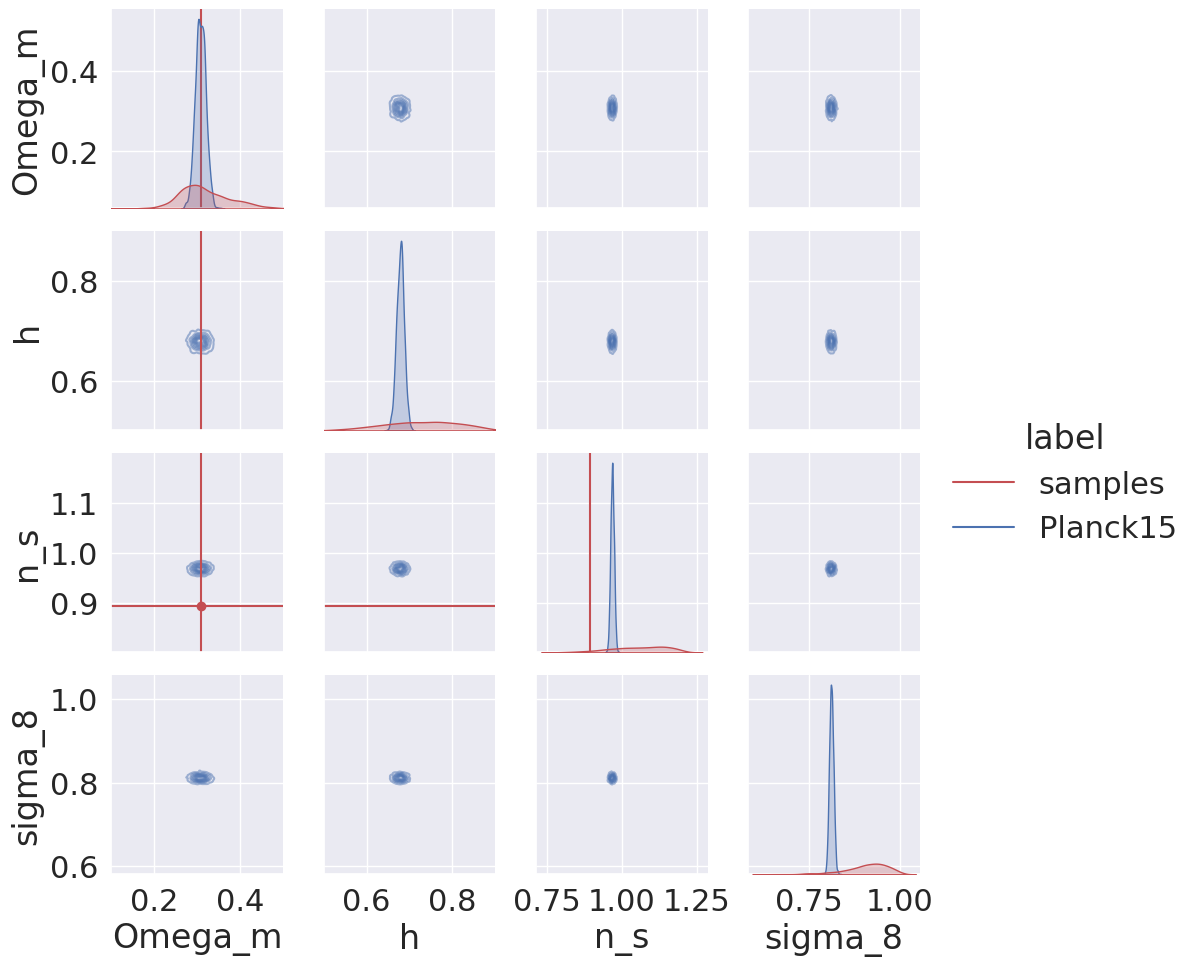

In [51]:
import seaborn as sns
theta_obs = thtrue[[0,2,3,4]]
stemp = pd.DataFrame(samples[:,[0,2,3,4]], columns=['Omega_m', 'h', 'n_s', 'sigma_8'])
stemp['label'] = 'samples'

x1['label'] = 'Planck15'
# sout = pd.concat([stemp, x1])
g = sns.pairplot(sout, kind='kde', diag_kind='kde', hue='label', palette=['r', 'b'])
# g.map_lower(sns.kdeplot, levels=3, color=".2")
# g.map_upper(sns.kdeplot, levels=3, color=".2")
sns.set(font_scale=2)

inds = [0,2,3,4]

ndim = len(theta_obs)
for i in range(ndim):
    for j in range(i + 1):
        if i == j:
            g.axes[i, i].axvline(theta_obs[inds[i]], color="r")
        else:
            g.axes[i, j].axhline(theta_obs[inds[i]], color="r")
            g.axes[i, j].axvline(theta_obs[inds[j]], color="r")
            g.axes[i, j].plot(theta_obs[inds[j]], theta_obs[inds[i]], "ro")
            g.axes[i,j].set_xlim(lmin[inds[j]], lmax[inds[j]])
            g.axes[i,j].set_ylim(lmin[inds[i]], lmax[inds[i]])



/home/mattho/git/ltu-ili/ili/validation/metrics.py:76: UserWarning: DirectPosterior detected. Ignoring mcmc sampler parameters.
  warnings.warn(
Drawing 335 posterior samples: 378it [00:00, 48046.76it/s]            
Drawing 303 posterior samples: 336it [00:00, 68322.40it/s]            
Drawing 362 posterior samples: 429it [00:00, 120422.73it/s]           

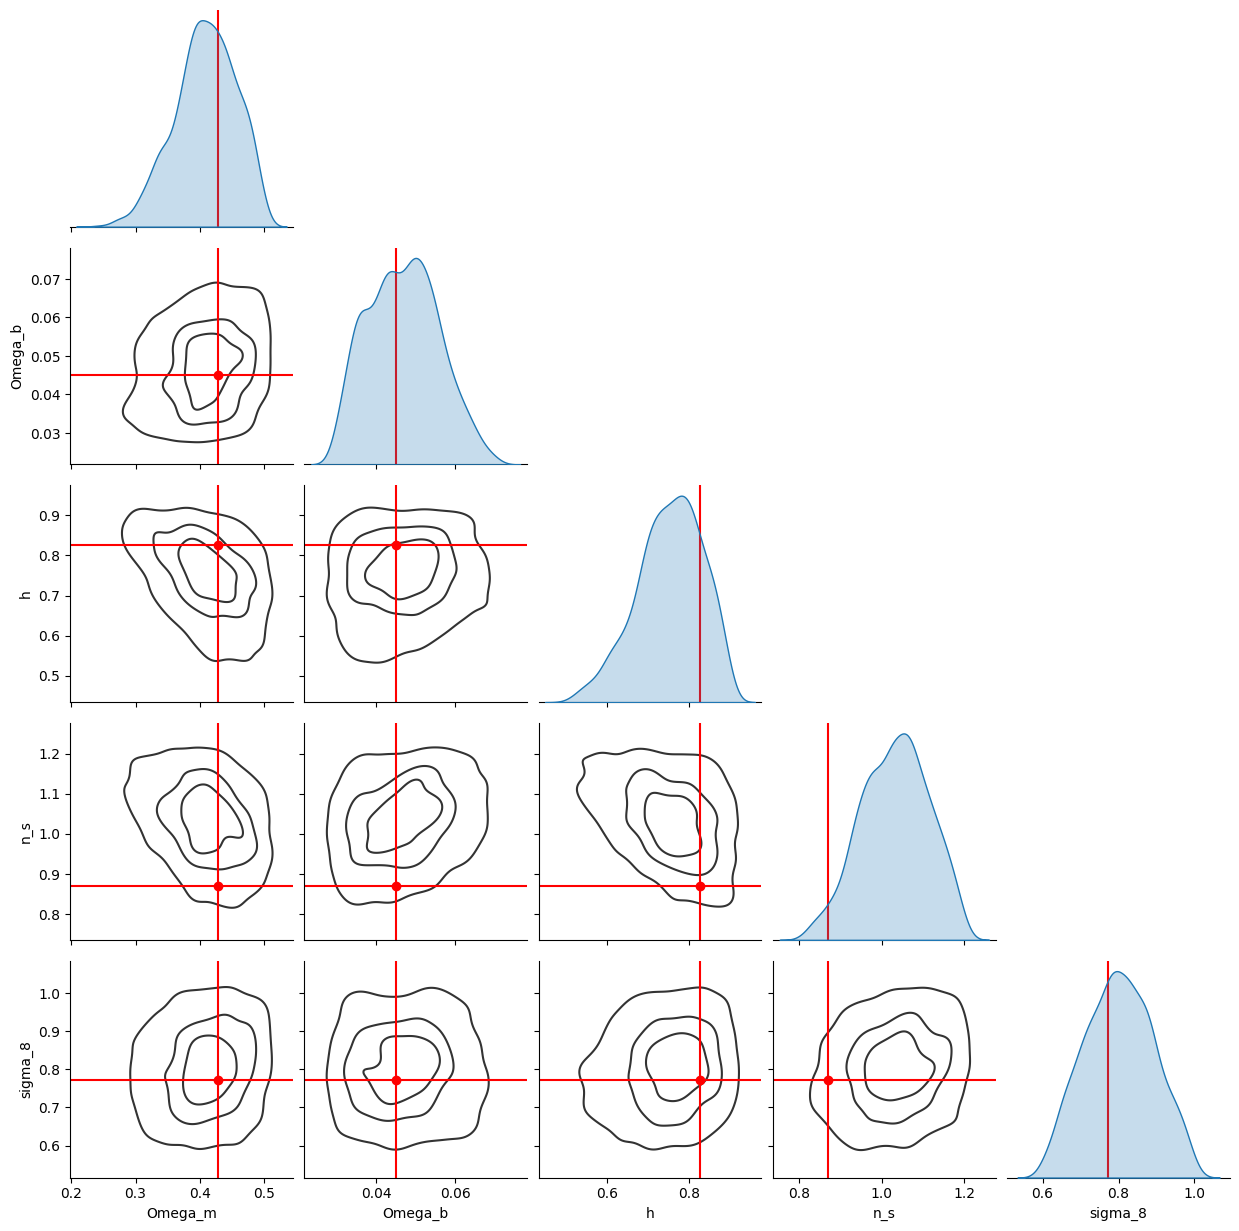

In [19]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=lh_lookup.columns
)
fig = metric(
    posterior=posterior,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

/home/mattho/git/ltu-ili/ili/validation/metrics.py:76: UserWarning: DirectPosterior detected. Ignoring mcmc sampler parameters.
  warnings.warn(
Drawing 328 posterior samples: 350it [00:00, 90696.06it/s]            
Drawing 342 posterior samples: 383it [00:00, 123116.07it/s]           
Drawing 330 posterior samples: 445it [00:00, 139590.55it/s]           

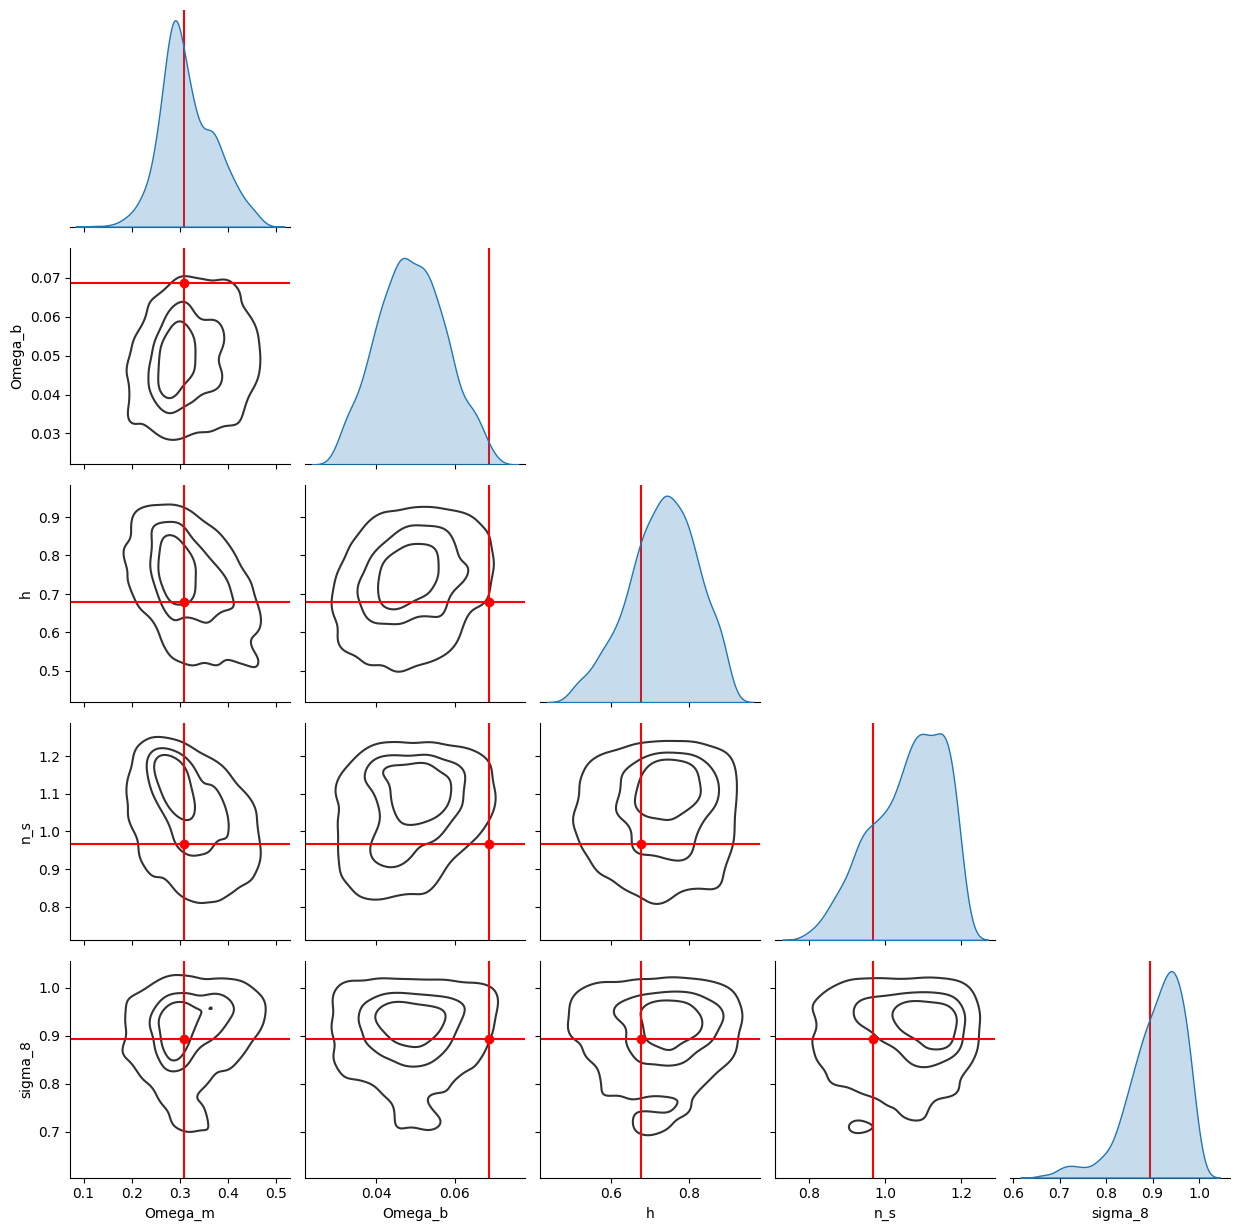

In [20]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point


metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=lh_lookup.columns
)
fig = metric(
    posterior=posterior,
    x_obs = Pktrue, theta_obs=lh_lookup.iloc[3],
    x=x, theta=theta
)

/home/mattho/git/ltu-ili/ili/validation/metrics.py:76: UserWarning: DirectPosterior detected. Ignoring mcmc sampler parameters.
  warnings.warn(
  2%|▏         | 181/10674 [00:01<01:23, 126.22it/s]

  5%|▌         | 584/10674 [00:04<01:19, 127.00it/s]WARNING:root:Only 0.269% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    12 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    23 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    -54 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  7%|▋         | 701/10674 [00:05<01:18, 126.83it/s]WARNING:root:Only 0.110% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    28 samples. Consider interrupting (

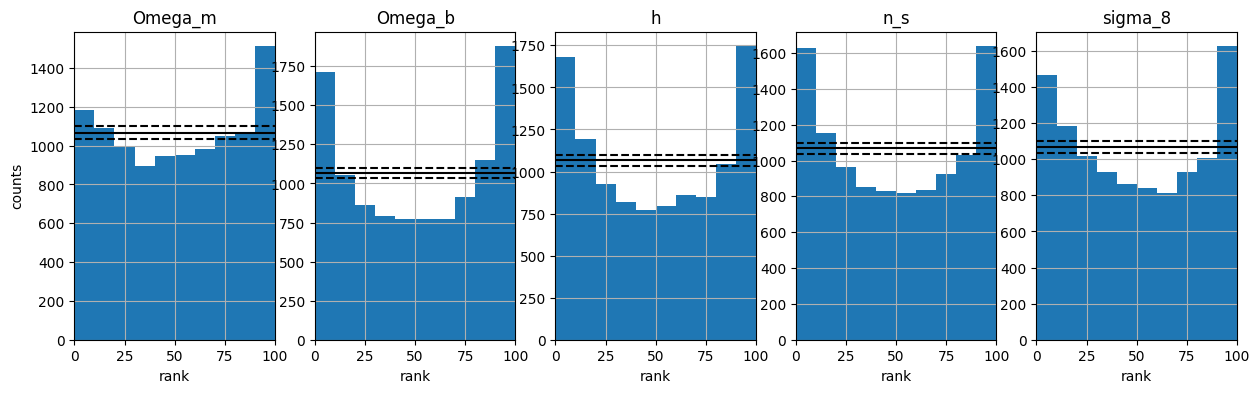

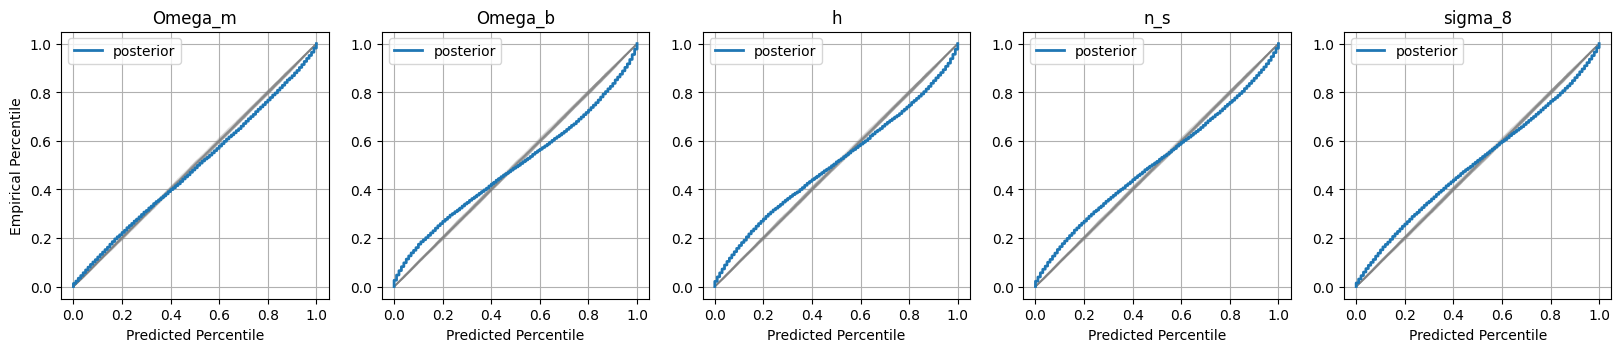

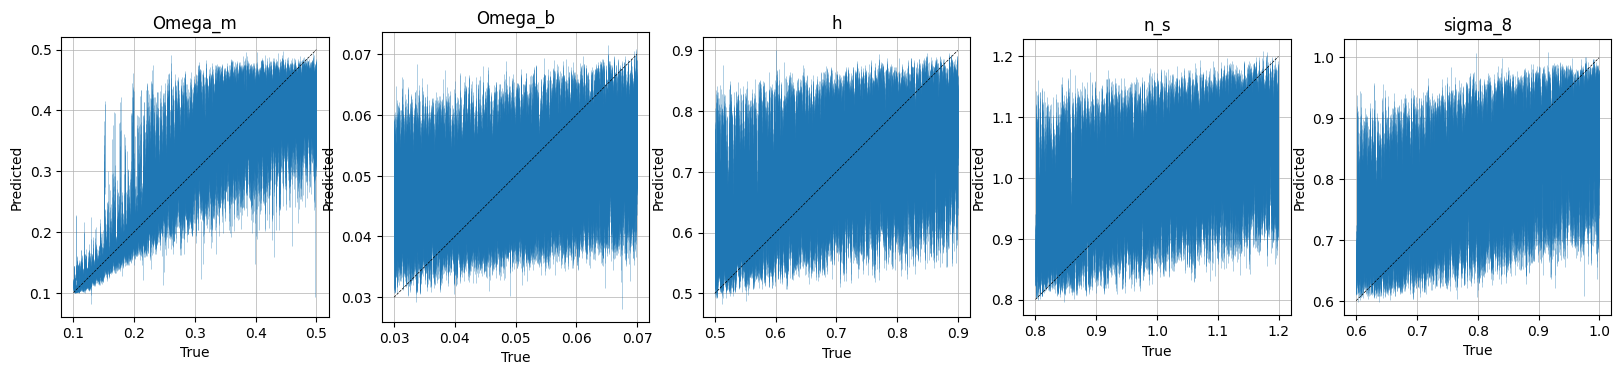

In [21]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='direct', labels=lh_lookup.columns
)
fig = metric(
    posterior=posterior,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

In [22]:
# calculate and plot the TARP metric to describe multivariate posterior coverage
metric = TARP(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='emcee'
)
fig = metric(
    posterior=posterior,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

  0%|          | 0/10674 [00:00<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

From these results, we see that we are largely consistent and calibrated in the univariate coverage, with some slight negative bias shown in the multivariate coverage. Though, this might largely be due to the low number of samples in our dataset.

## Toy SNLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.

In [2]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.linspace(0, 10, 20)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += 1*np.random.randn(len(x))
    return y

theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

In [3]:
# define a prior
prior = sbi.utils.BoxUniform(low=(0,0,0), high=(1,1,1), device=device)

# define an inference class (here, we are doing amortized likelihood inference)
inference_class = sbi.inference.SNLE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.likelihood_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.likelihood_nn(model='made', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [4]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=loader)
posterior._weights = posterior._weights.to('cuda')

INFO:root:Training model 1 out of 2 ensemble models


 Neural network successfully converged after 540 epochs.

INFO:root:Training model 2 out of 2 ensemble models


 Neural network successfully converged after 323 epochs.

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 58.54638600349426 seconds to train all models.


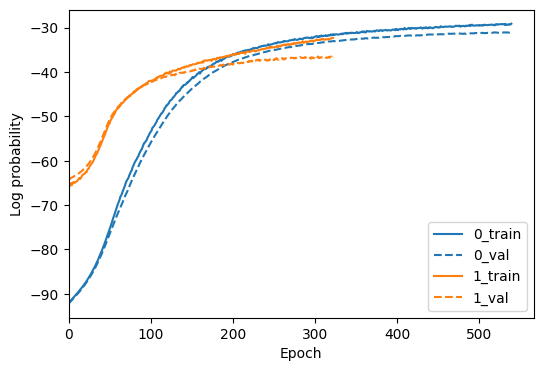

In [5]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [12]:
# choose a random input
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior.sample(
    (1000,), x[ind], 
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior.log_prob(
    samples, 
    x[ind]
).detach().cpu().numpy()

Running vectorized MCMC with 6 chains: 100%|█████████▉| 5940/5964 [00:37<00:00, 160.48it/s]
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:172: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the
            log-probability up to a normalizing constant. Use `.potential()` instead.
  warn(
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:176: UserWarning: The log-probability is unnormalized!
  warn("The log-probability is unnormalized!")


Note: Amortized liklihood estimators do not directly estimate the posterior, but instead build a model for the relative likelihood. This can be combined with a prior to estimate the potential function, which is proportional to the log_probability up to a normalizing constant. Hence, we use MCMC sampling for SNLE models to probe the posterior distribution.

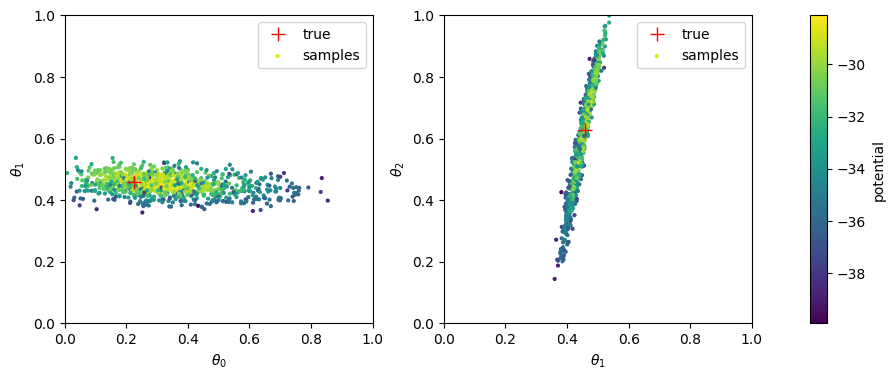

In [13]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

Running vectorized MCMC with 8 chains:   0%|          | 0/5264 [00:00<?, ?it/s]

Running vectorized MCMC with 8 chains: 100%|█████████▉| 6320/6344 [00:30<00:00, 208.35it/s]


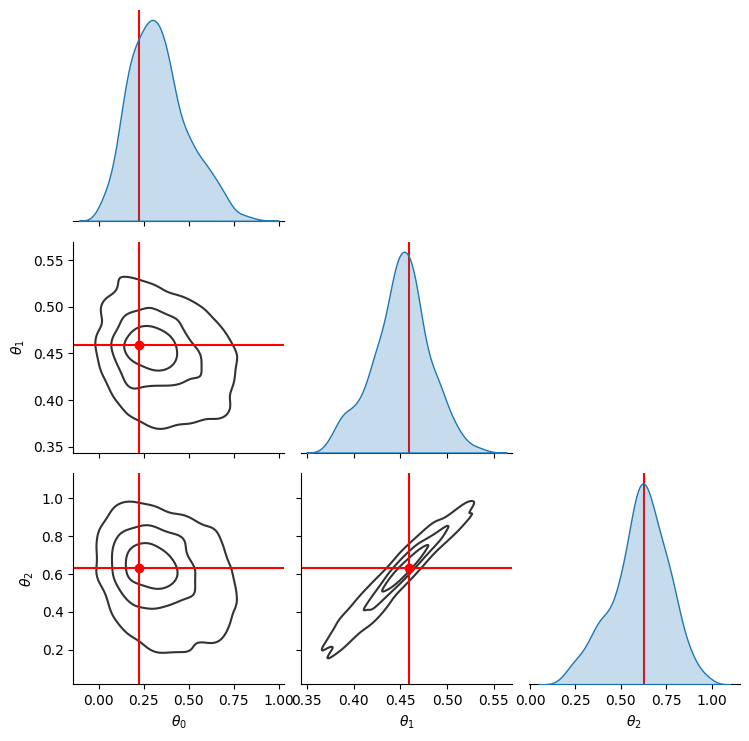

In [14]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior, 
    x_obs = x[ind], theta_obs=theta[ind], 
    x=x, theta=theta
)

100%|██████████| 200/200 [32:51<00:00,  9.86s/it]


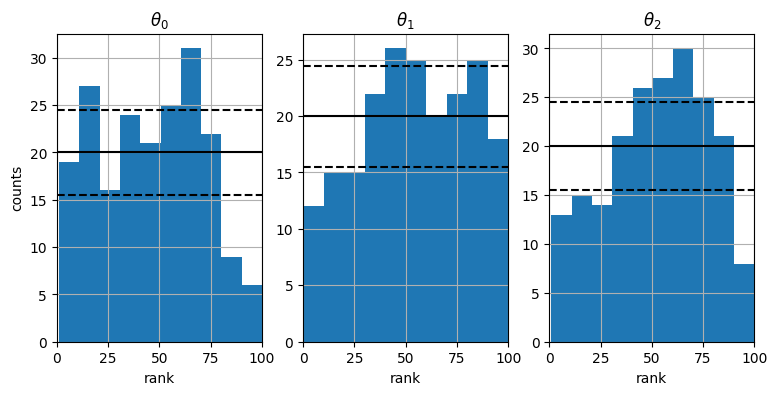

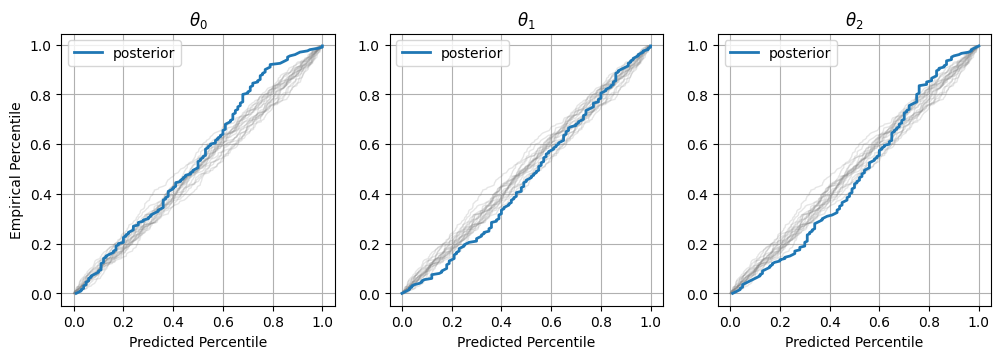

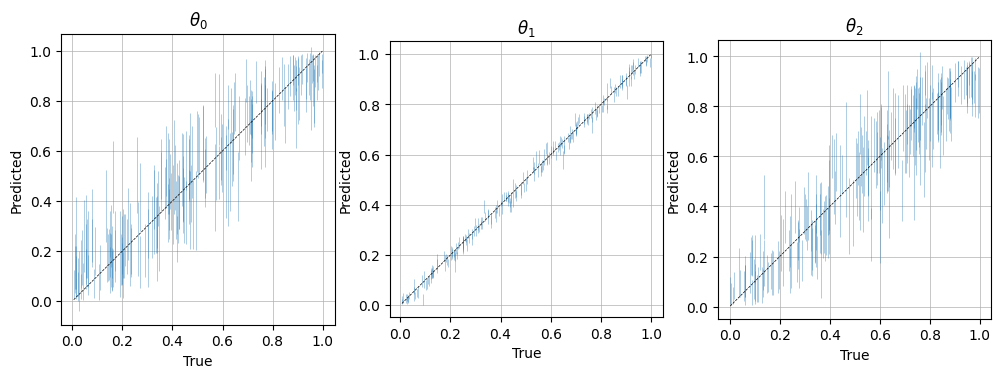

In [27]:
# calculate and plot the rank statistics to describe univariate posterior coverage
# (note, with MCMC this takes a while)
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior,
    x=x, theta=theta
)

100%|██████████| 200/200 [32:34<00:00,  9.77s/it]


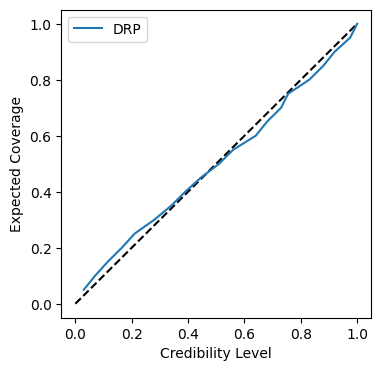

In [28]:
# calculate and plot the TARP metric to describe multivariate posterior coverage
# (note, with MCMC this takes a while)
metric = TARP(
    backend='sbi', output_path=None, num_samples=100, 
    sample_method='slice_np_vectorized',
    sample_params={'num_chains': 6, 'burn_in':20, 'thin': 3},
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

Looks like we're well-calibrated, with tight constraints on $\theta_1$!

## CAMELS CMD 2D SNPE
The real utility of ltu-ili is in its flexibility for applicaiton to a wide variety of real datasets. Through the use of customizable embedding networks, this framework can be extended to handle e.g. image, point cloud, or time-series inputs.

In this example, our inputs are 2D slices of the gas temperature of the simulations in the [CAMELS Multifield Dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/) and our target parameters are 6 cosmological and astrophysical parameters (Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2) that were used to run the simulation. This inference pipeline follows the procedure of the [CAMELS 2D Inference colab example](https://colab.research.google.com/drive/1-BmkA8JSc36O8g9pj7FenD1YSLKqjQR3?usp=sharing).

In [63]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)

!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3750M  100 3750M    0     0  32.9M      0  0:01:53  0:01:53 --:--:-- 15.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48000  100 48000    0     0   105k      0 --:--:-- --:--:-- --:--:--  105k


In [2]:
# load data
x = np.log10(np.load('./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy'))
theta = np.loadtxt('./toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

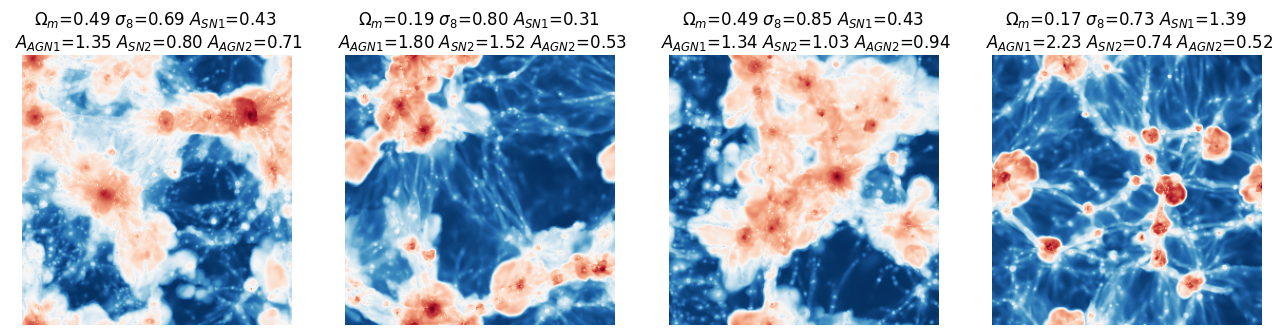

In [3]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [4]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [5]:
# define a prior
prior = sbi.utils.BoxUniform(low=prior_min, high=prior_max, device=device)

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='mdn', embedding_net=embedding_net, hidden_features=16, num_components=1),
    sbi.utils.posterior_nn(model='maf', embedding_net=embedding_net, hidden_features=16, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [6]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=loader)

INFO:root:Training model 1 out of 2 ensemble models
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/user_input_checks.py:435: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cpu' vs embedding_net weights have device 'cuda:0'. Automatically switching the embedding_net's device to 'cpu', which could otherwise be done manually using the line `embedding_net.to('cpu')`.
  warnings.warn(


 Training neural network. Epochs trained: 176

INFO:root:Training model 2 out of 2 ensemble models


 Neural network successfully converged after 187 epochs.

/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 1006.7971565723419 seconds to train all models.


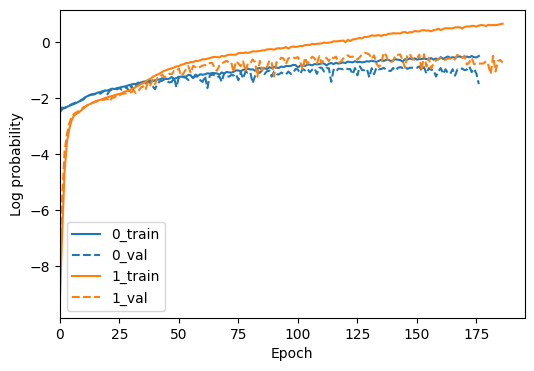

In [8]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [9]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/pyknos/mdn/mdn.py:283: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(
Drawing 690 posterior samples: 886it [00:00, 72096.72it/s]            
Drawing 310 posterior samples: 337it [00:00, 14858.88it/s]            


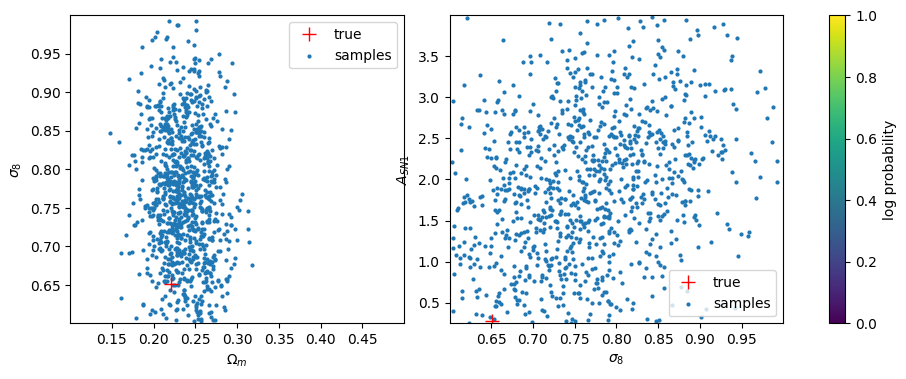

In [10]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

/home/mattho/git/ltu-ili/ili/validation/metrics.py:76: UserWarning: DirectPosterior detected. Ignoring mcmc sampler parameters.
  warnings.warn(
Drawing 677 posterior samples: 811it [00:00, 175737.78it/s]           
Drawing 323 posterior samples: 354it [00:00, 15632.59it/s]            


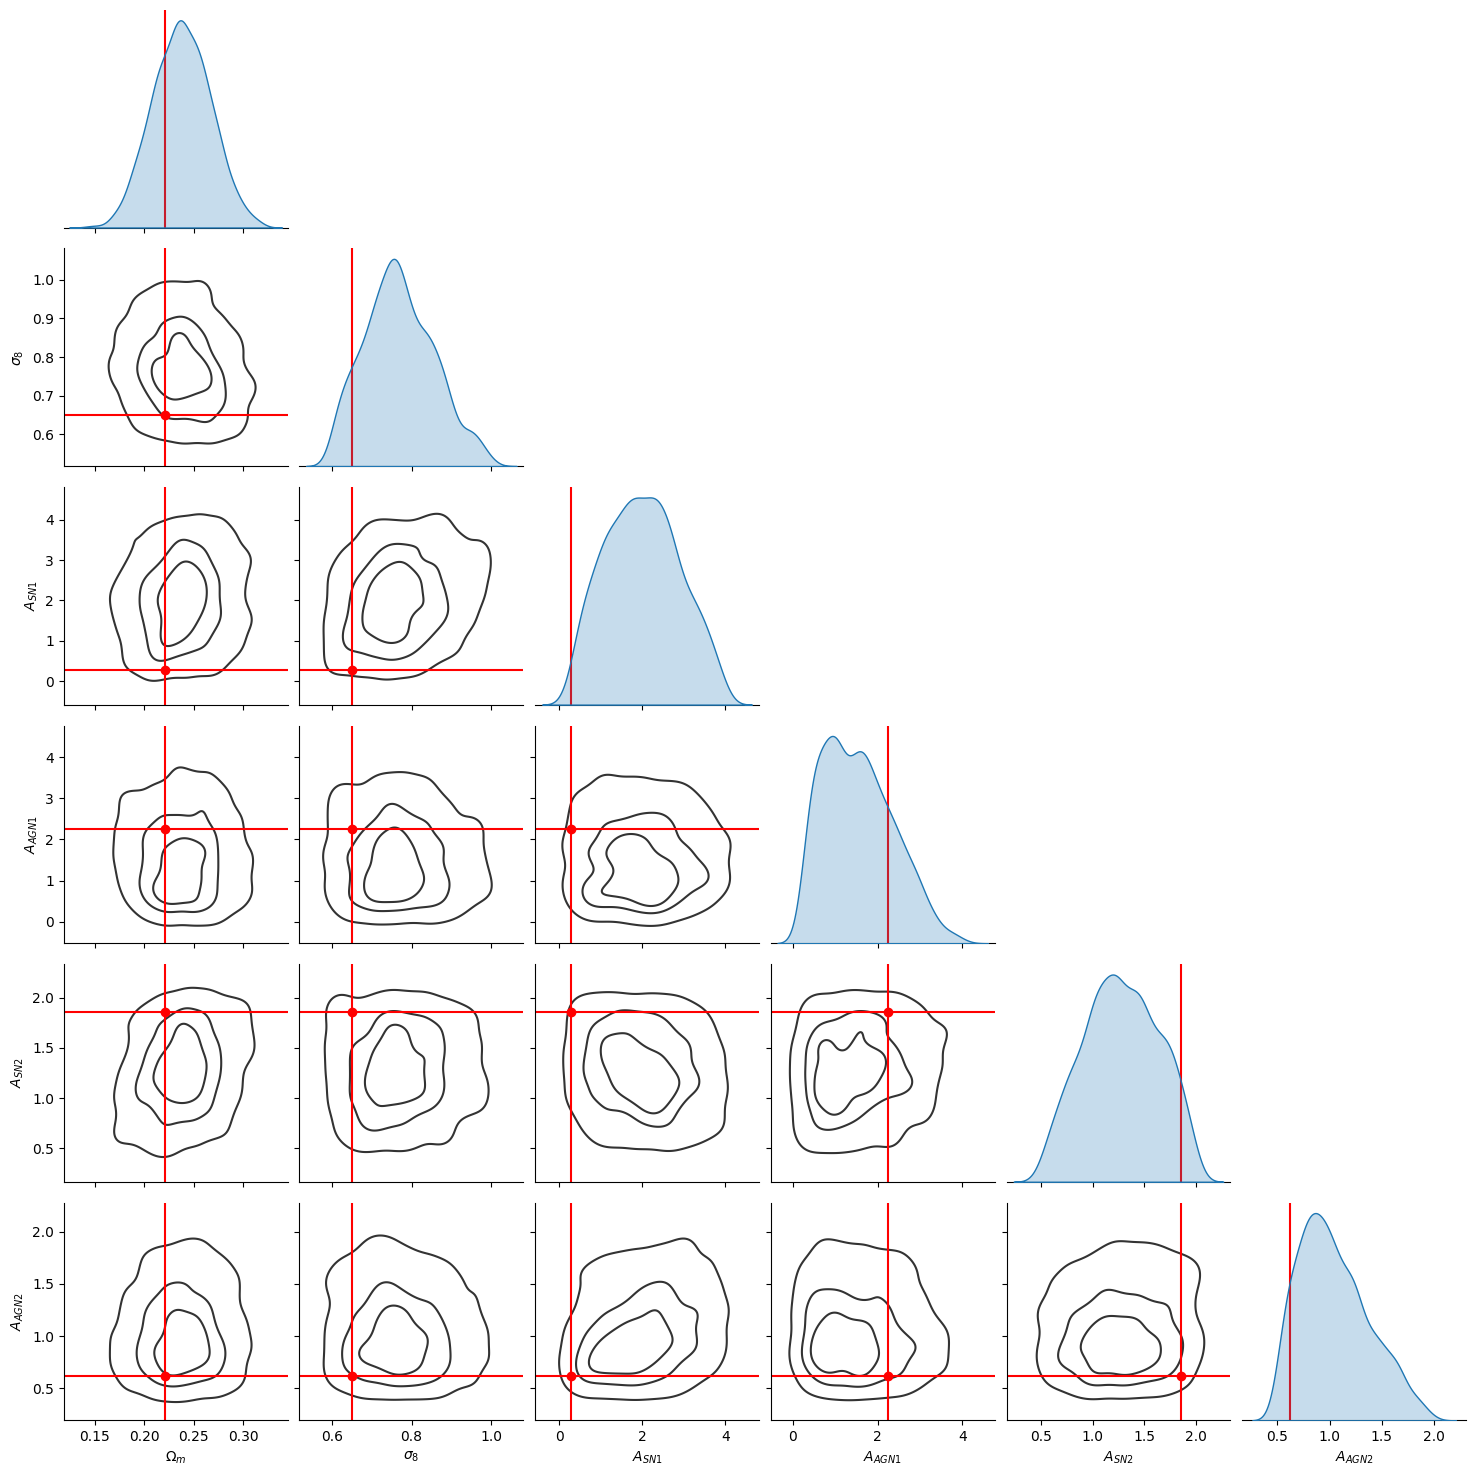

In [11]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=labels
)
fig = metric(
    posterior=posterior,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)

100%|██████████| 938/938 [00:23<00:00, 39.18it/s]


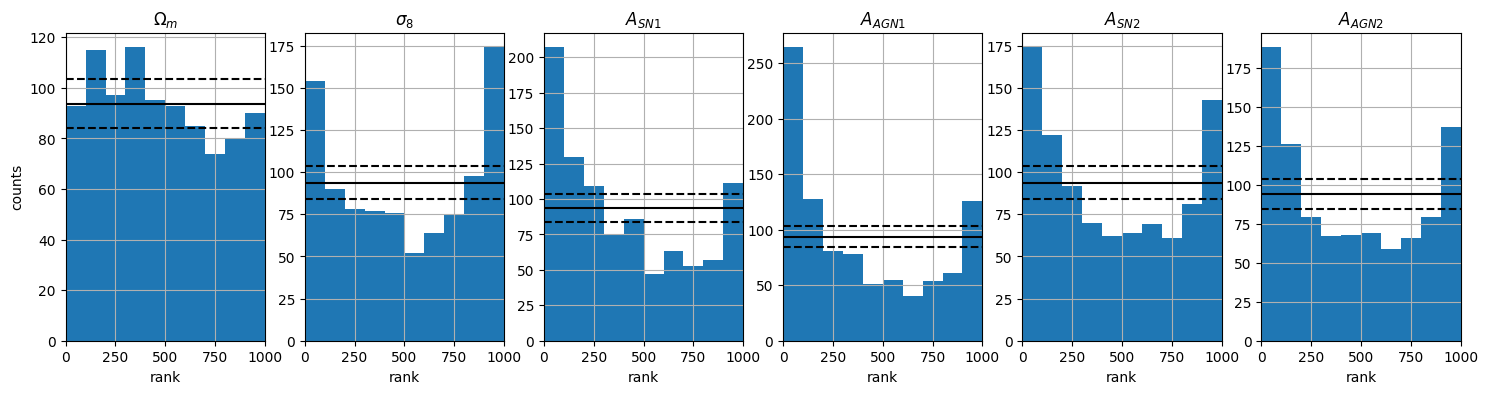

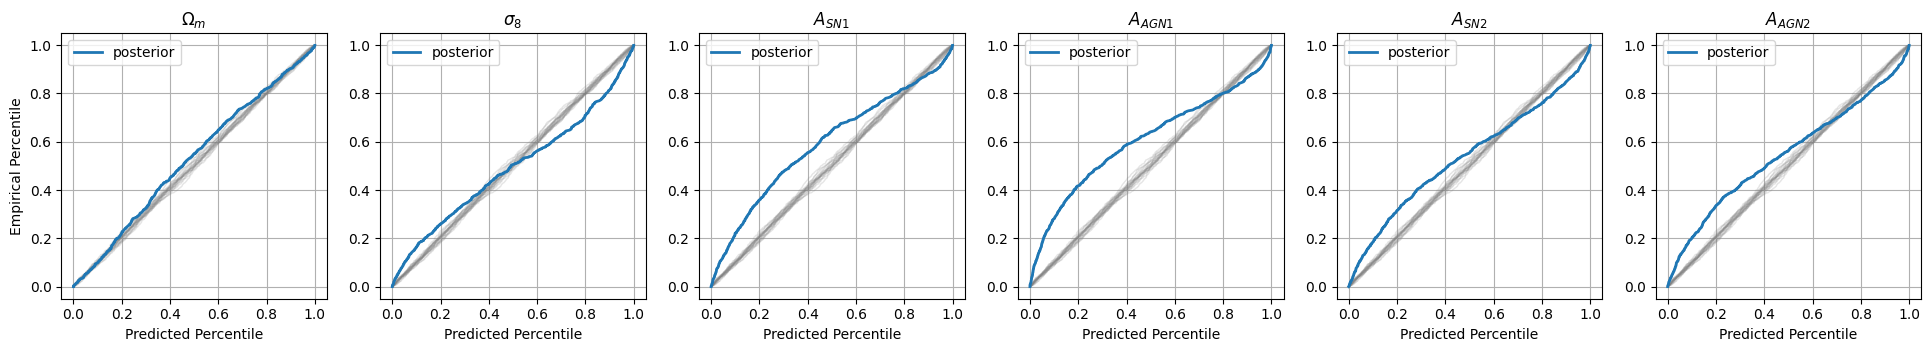

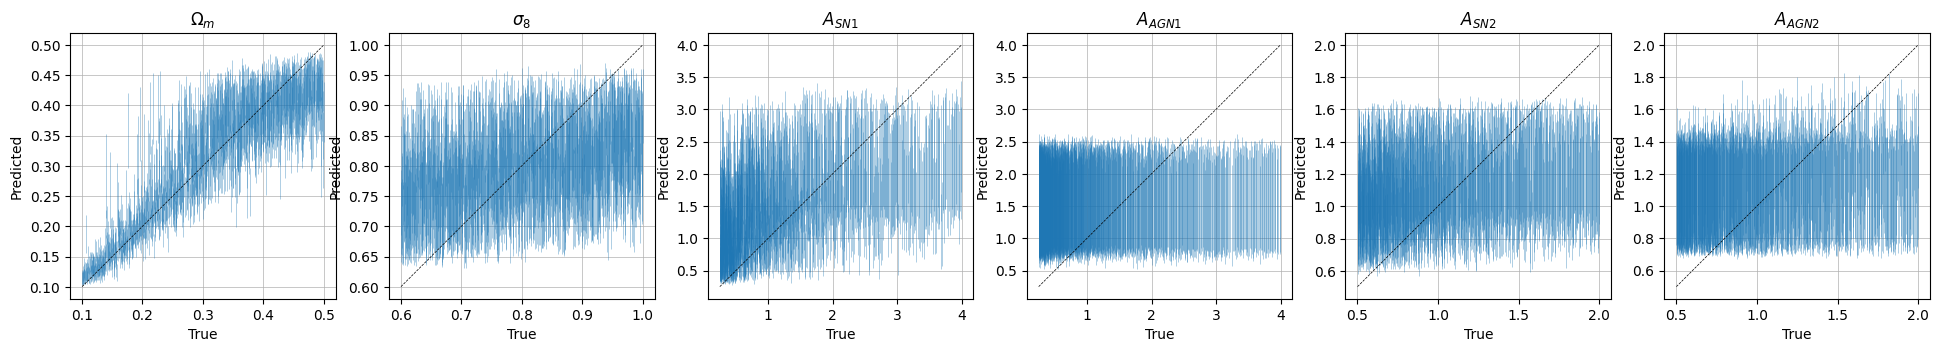

In [14]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct', labels=labels
)
fig = metric(
    posterior=posterior,
    x=x[::8], theta=theta[::8]
)

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:23<00:00, 39.40it/s]


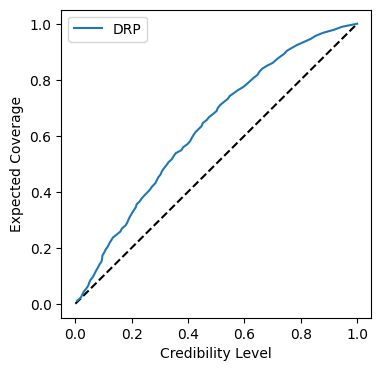

In [15]:
# calculate and plot the TARP metric to describe multivariate posterior coverage
metric = TARP(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='direct'
)
fig = metric(
    posterior=posterior,
    x=x[::8], theta=theta[::8]
)

As you can see, we are picking up on clear information on $\Omega_m$ and some on $\sigma_8$, but not much on the other parameters. This mimics the finding of the CAMELS CMD example, albeit with worse constraints (likely since we have not optimized our CNN architecture). Nonetheless, this demonstrates how the ltu-ili framework can be used to perform inference on real datasets using customizable embedding networks.